In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
from PIL import Image
from skimage.feature import graycomatrix, graycoprops, hog, local_binary_pattern
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Global variables :
train_pneumonia_dir = "data/row/train/PNEUMONIA/"
train_normal_dir = "data/row/train/NORMAL/"
test_pneumonia_dir = "data/row/test/PNEUMONIA/"
test_normal_dir = "data/row/test/NORMAL/"
val_pneumonia_dir = "data/row/val/PNEUMONIA/"
val_normal_dir = "data/row/val/NORMAL/"

# Training dataset
pneumonia_train = sorted(glob.glob(train_pneumonia_dir + "*"))
normal_train = sorted(glob.glob(train_normal_dir + "*"))

# Test dataset
pneumonia_test = sorted(glob.glob(test_pneumonia_dir + "*"))
normal_test = sorted(glob.glob(test_normal_dir + "*"))

# Validation dataset
pneumonia_val = sorted(glob.glob(val_pneumonia_dir + "*"))
normal_val = sorted(glob.glob(val_normal_dir + "*"))

# Dataset

In [3]:
def ordinal_plot(label, label_masked, title, label_name="Label", mask_name="Masked"):
    plt.bar(label.keys(), label.values(), color='lightblue', label='Total')
    plt.bar(label_masked.keys(), label_masked.values(), color='orange', alpha=0.7, label=mask_name)
    plt.xlabel(label_name.title().replace('_', ' '))
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()

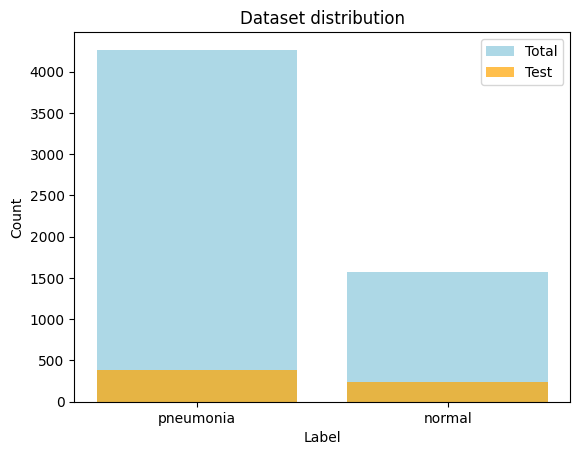

In [4]:
length = {"pneumonia": len(pneumonia_train) + len(pneumonia_test), "normal": len(normal_train) + len(normal_test)}
length_ts = {"pneumonia": len(pneumonia_test), "normal": len(normal_test)}
ordinal_plot(length, length_ts, "Dataset distribution", label_name="Label", mask_name="Test")

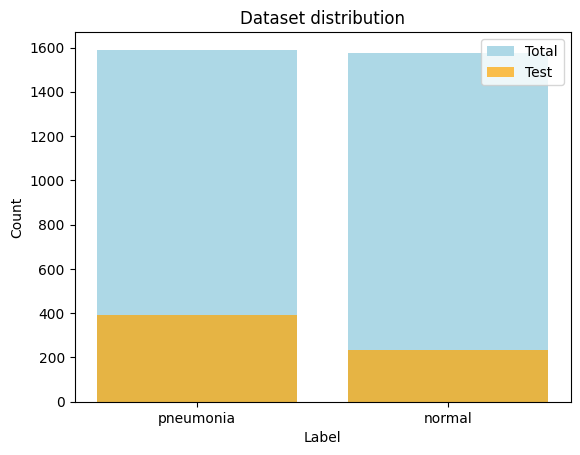

In [5]:
length = {"pneumonia": len(pneumonia_train[:1200]) + len(pneumonia_test), "normal": len(normal_train) + len(normal_test)}
length_ts = {"pneumonia": len(pneumonia_test), "normal": len(normal_test)}
ordinal_plot(length, length_ts, "Dataset distribution", label_name="Label", mask_name="Test")

In [6]:
p_w = np.zeros(shape=len(pneumonia_train), dtype=int)
p_l = np.zeros(shape=len(pneumonia_train), dtype=int)

for i, img in enumerate(pneumonia_train):
    m = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    w, l = m.shape
    p_w[i] = w
    p_l[i] = l

n_w = np.zeros(shape=len(normal_train), dtype=int)
n_l = np.zeros(shape=len(normal_train), dtype=int)

for i, img in enumerate(normal_train):
    m = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    w, l = m.shape
    n_w[i] = w
    n_l[i] = l    

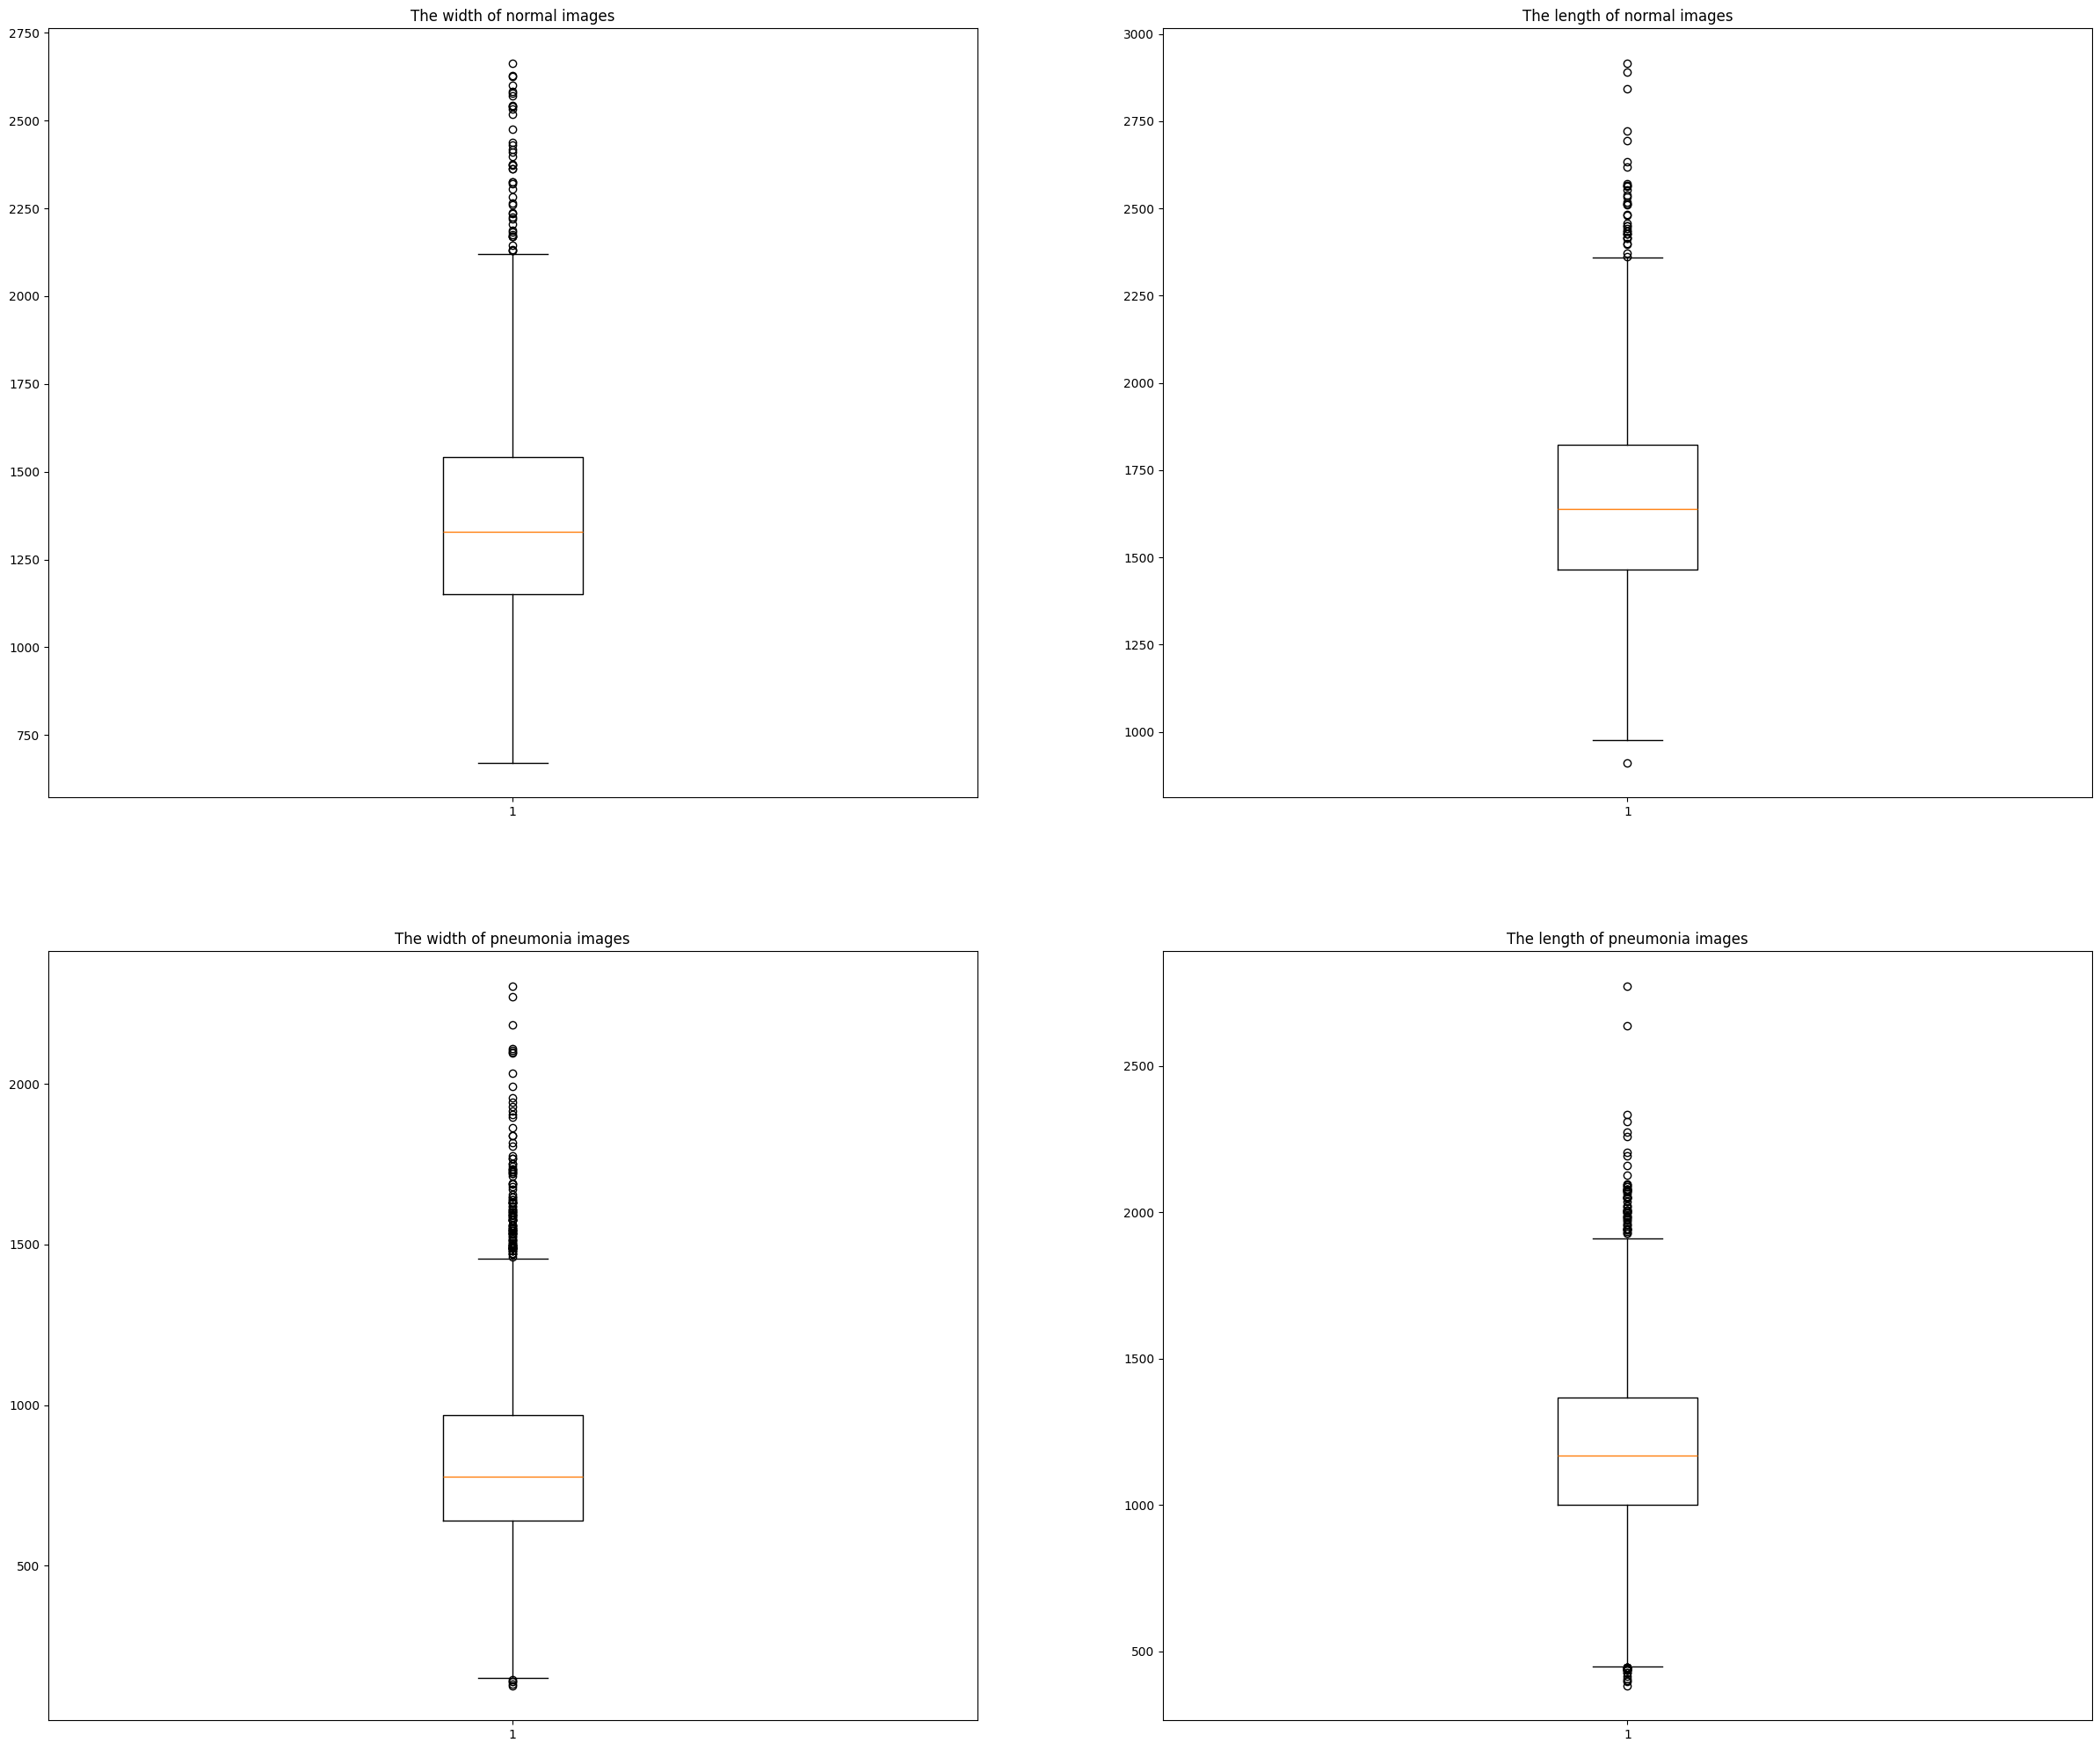

In [7]:
plt.figure(figsize=[30, 25])

plt.subplot(221)
plt.title("The width of normal images")
plt.boxplot(n_w)

plt.subplot(222)
plt.title("The length of normal images")
plt.boxplot(n_l)

plt.subplot(223)
plt.title("The width of pneumonia images")
plt.boxplot(p_w)

plt.subplot(224)
plt.title("The length of pneumonia images")
plt.boxplot(p_l)

plt.show()

# Visualising images

## pneumonia

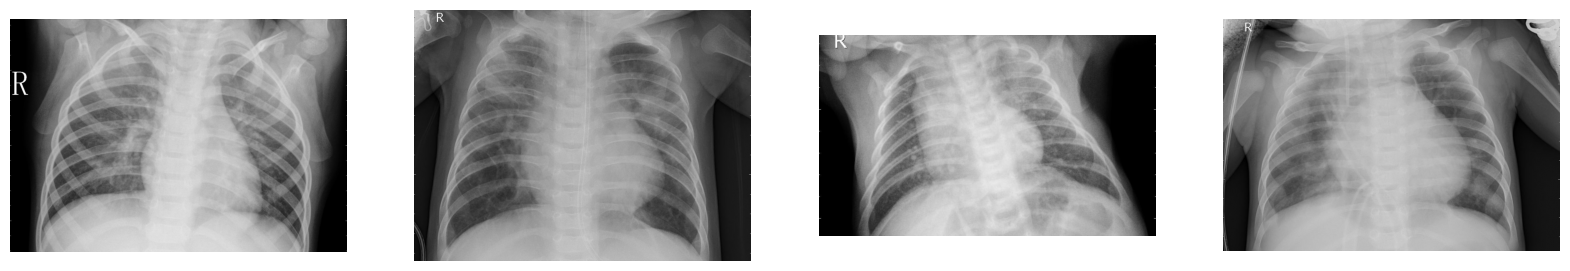

In [8]:
plt.figure(figsize=[20, 80])
np.random.shuffle(pneumonia_train)
pneumonia_img = [cv2.imread(pneumonia_train[i], cv2.IMREAD_GRAYSCALE) for i in range(4)]
#plt.title("radiographies des gens souffrants de pneumonie")
plt.subplot(141), plt.axis('off')
plt.imshow(pneumonia_img[0], cmap=('gray'))
plt.subplot(142), plt.axis('off')
plt.imshow(pneumonia_img[1], cmap=('gray'))
plt.subplot(143), plt.axis('off')
plt.imshow(pneumonia_img[2], cmap=('gray'))
plt.subplot(144), plt.axis('off')
plt.imshow(pneumonia_img[3], cmap=('gray'))

## normal

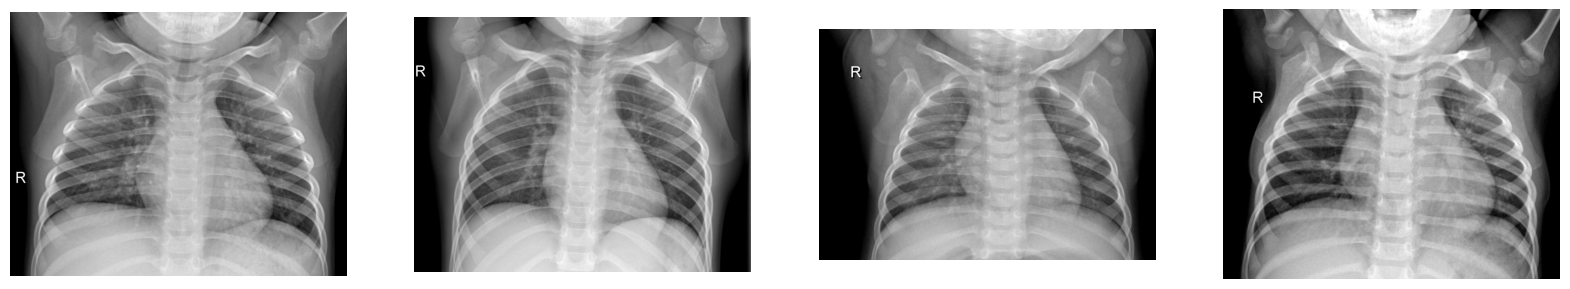

In [9]:
plt.figure(figsize=[20, 80])
np.random.shuffle(normal_train)
normal_img = [cv2.imread(normal_train[i], cv2.IMREAD_GRAYSCALE) for i in range(5)]

plt.subplot(141), plt.axis('off')
plt.imshow(normal_img[0], cmap=('gray'))
plt.subplot(142), plt.axis('off')
plt.imshow(normal_img[1], cmap=('gray'))
plt.subplot(143), plt.axis('off')
plt.imshow(normal_img[2], cmap=('gray'))
plt.subplot(144), plt.axis('off')
plt.imshow(normal_img[3], cmap=('gray'))

# Preprocessing

In [10]:
def preprocess_xray(path, size=(224, 224), normalise=False):
    img = Image.open(path).convert("L")
    img.thumbnail(size, Image.BICUBIC)

    canvas = Image.new("L", size, 0)
    x = (size[0] - img.size[0]) // 2
    y = (size[1] - img.size[1]) // 2
    canvas.paste(img, (x, y))

    img_np = np.array(canvas, dtype=np.float32)
    if normalise:
        img_np = (img_np - img_np.mean()) / (img_np.std() + 1e-8)
    return img_np

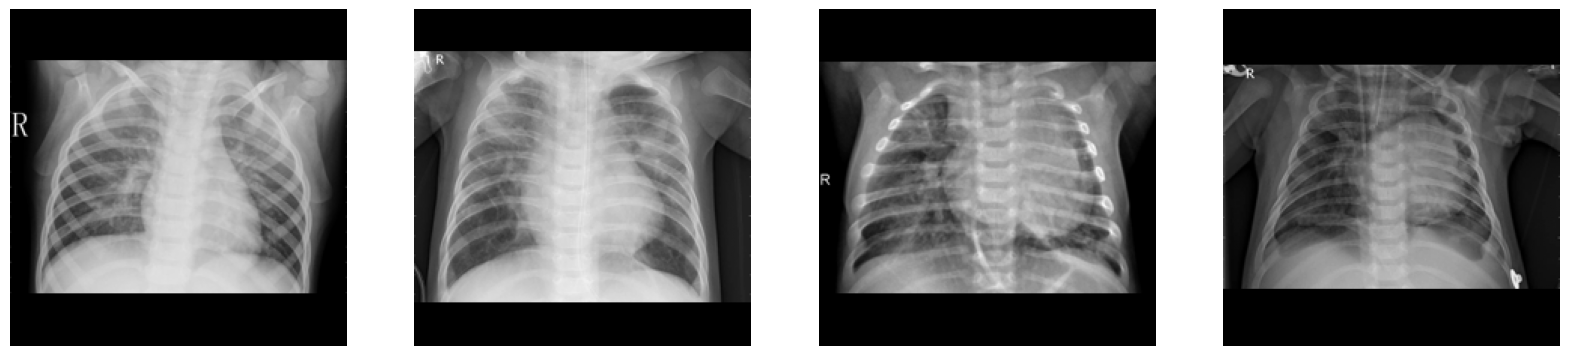

In [11]:
plt.figure(figsize=[20, 80])

plt.subplot(141), plt.axis('off')
plt.imshow(preprocess_xray(pneumonia_train[0]), cmap=('gray'))
plt.subplot(142), plt.axis('off')
plt.imshow(preprocess_xray(pneumonia_train[1]), cmap=('gray'))
plt.subplot(143), plt.axis('off')
plt.imshow(preprocess_xray(pneumonia_test[0]), cmap=('gray'))
plt.subplot(144), plt.axis('off')
plt.imshow(preprocess_xray(pneumonia_test[1]), cmap=('gray'))

# Features extraction

## First order Statistical features

In [12]:
def stats_features(dir_images, label):
    stats_features = []
    for i in range(len(dir_images)):
        img = preprocess_xray(dir_images[i])
        mean = np.mean(img)
        std = np.std(img)
        id = dir_images[i].split("\\")[1]
        stats_features.append((id, mean, std, label))
    
    columns = ['id',  'mean', 'std', 'label']
    return pd.DataFrame(stats_features, columns=columns)

In [16]:
dfP = stats_features(pneumonia_train, 1)
dfN = stats_features(normal_train, 0)

stat_train = pd.concat([dfP, dfN])

In [ ]:
dfP = stats_features(pneumonia_test, 1)
dfN = stats_features(normal_test, 0)

stat_test = pd.concat([dfP, dfN])

## Haralick features

### Descripteur Extraction

In [13]:
# Gray Level Co-Occurences Matrix (GLCM)
def haralick_features(dir_images, label):
    descriptor = []
    for i in range(len(dir_images)):
        img = preprocess_xray(dir_images[i])
        img = (img // 16).astype(np.uint8)
        id = dir_images[i].split("\\")[1]
        haralick = [id]
        # Cooccurences matrix with (distance=1, angle=[0, 45, 90, 135]) 
        distances = [i for i in range(1, 11)]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        GLCM = graycomatrix(img, distances, angles, symmetric=False, normed=True, levels=16)
        features = ["contrast", "entropy", "homogeneity"]
        for feature in features:
            for d in range(len(distances)):
                for a in range(len(angles)):
                    haralick.append(graycoprops(GLCM, feature)[d, a])
        haralick.append(label)
        descriptor.append(haralick)            

    columns = ['id']    
    for feature in features:
            for d in distances:
                for a in angles:
                    columns.append(f"{feature}_{d}_{a}")
    columns.append('label')
    return pd.DataFrame(descriptor, columns=columns)

### CSV file generation

In [ ]:
# Haralick texture features of the Training dataset
df1 = haralick_features(pneumonia_train[:1200], 1)
df2 = haralick_features(normal_train, 0)

haralick_train = pd.concat([df1, df2])
train = pd.merge(stat_train, haralick_train, on="id")
train = train.drop("label_x", axis='columns')
train = train.rename({"label_y" : "label"})
train.to_csv('data/processed/train_stats.csv', index=False)

In [ ]:
# Haralick texture features of the Test dataset
df1 = haralick_features(pneumonia_test, 1)
df2 = haralick_features(normal_test, 0)

haralick_test = pd.concat([df1, df2])
test = pd.merge(stat_test, haralick_test, on="id")
test = test.drop("label_x", axis='columns')
test = test.rename({"label_y" : "label"})
test.to_csv('data/processed/test_stats.csv', index=False)

### importing data 

In [15]:
# importing data
train_st = pd.read_csv('data/processed/train_stats.csv')
test_st = pd.read_csv('data/processed/test_stats.csv')

# training data
Y_train_st = train_st['label_y']
X_train_st = train_st.drop(columns=['id', 'label_y'])

# testing data
Y_test_st = test_st['label_y']
X_test_st = test_st.drop(columns=['id', 'label_y'])

### t-sne

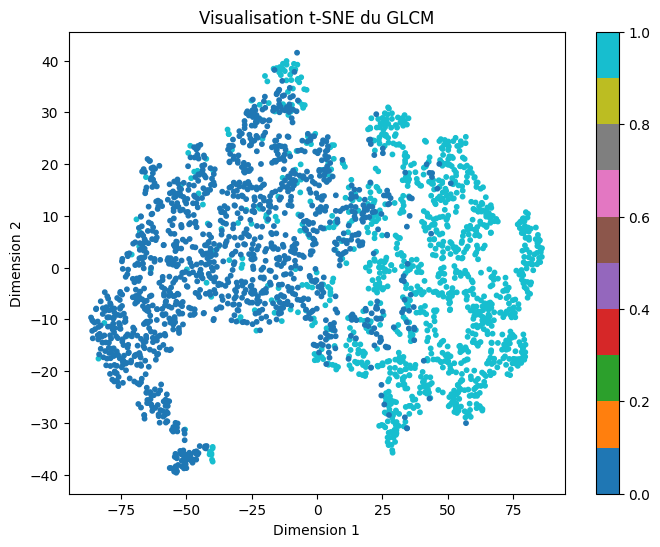

In [16]:
X_scaled_st = StandardScaler().fit_transform(X_train_st)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled_st)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=Y_train_st, cmap='tab10', s=10)
plt.colorbar()
plt.title("Visualisation t-SNE du GLCM")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### visualisation

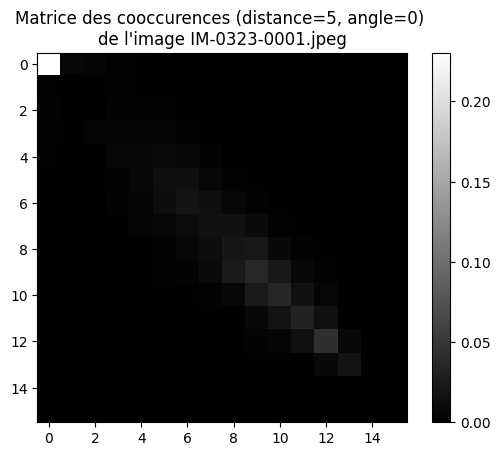

In [17]:
img = preprocess_xray(normal_train[0])
img = (img // 16).astype(np.uint8)
id = normal_train[0].split("\\")[1]
haralick = [id]
# Cooccurences matrix with (distance=1, angle=[0, 45, 90, 135]) 
distances = [i for i in range(1, 11)]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GLCM = graycomatrix(img, distances, angles, symmetric=False, normed=True, levels=16)
plt.imshow(GLCM[:, :, 4, 0], cmap="gray")
plt.title("Matrice des cooccurences (distance=5, angle=0) \nde l'image " + id)
plt.colorbar()
plt.show()

## HoG descriptor

### Descripteur Extraction

In [18]:
# cnfiguration du HoG
def extract_hog(img):
    features = hog(
        img,
        orientations=4,
        pixels_per_cell=(32, 32),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        visualize=False
    )
    return features

def HoG_features(dir_images, label):
    hog_features = []
    for i in range(len(dir_images)):
        img = preprocess_xray(dir_images[i])
        features = list(extract_hog(img))
        id = dir_images[i].split("\\")[1]
        features.append(label)
        features.insert(0, id)
        hog_features.append(features)
    
    columns = [f"hog{i}" for i in range(len(features) - 2)]
    columns.insert(0, "id")
    columns.append("label")
    return pd.DataFrame(hog_features, columns=columns)

### CSV file generation

In [77]:
# Training dataset
dfP = HoG_features(pneumonia_train[:1200], 1)
dfN = HoG_features(normal_train, 0)

HoG_train = pd.concat([dfP, dfN])
HoG_train.to_csv('train_hog.csv', index=False)

In [78]:
# Test dataset
dfP = HoG_features(pneumonia_test, 1)
dfN = HoG_features(normal_test, 0)

HoG_test = pd.concat([dfP, dfN])
HoG_test.to_csv('test_hog.csv', index=False)

### importing data

In [19]:
# importing data
train_hog = pd.read_csv('data/processed/train_hog.csv')
test_hog = pd.read_csv('data/processed/test_hog.csv')

# training data
Y_train_hog = train_hog['label']
X_train_hog = train_hog.drop(columns=['id', 'label'])

# testing data
Y_test_hog = test_hog['label']
X_test_hog = test_hog.drop(columns=['id', 'label'])

### t-sne

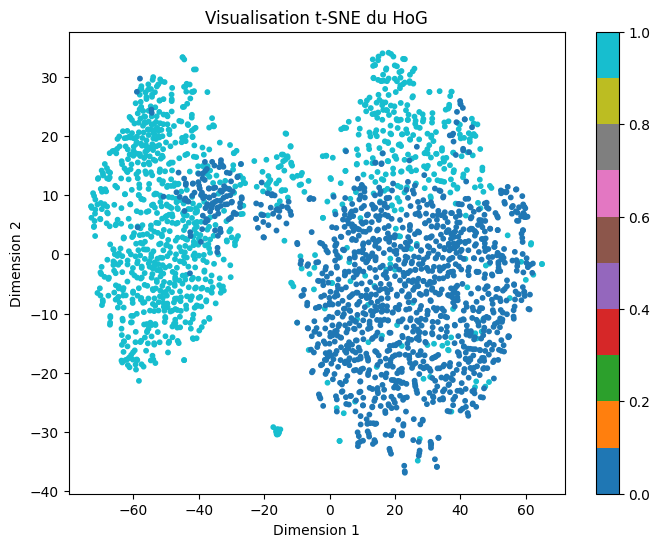

In [20]:
X_scaled_hog = StandardScaler().fit_transform(X_train_hog)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled_hog)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=Y_train_hog, cmap='tab10', s=10)
plt.colorbar()
plt.title("Visualisation t-SNE du HoG")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### visualisation

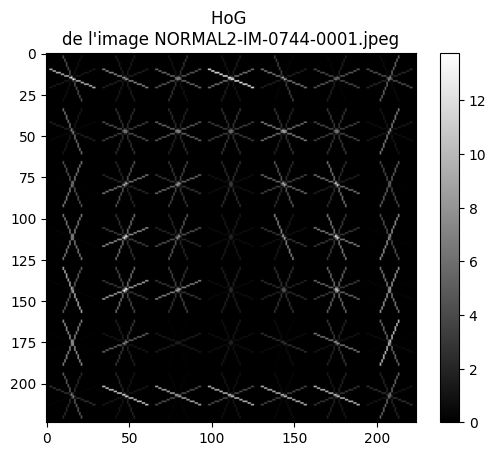

In [21]:
img = preprocess_xray(normal_train[7])
id = normal_train[7].split("\\")[1]
haralick = [id]
features, visu = hog(img, orientations=4, pixels_per_cell=(32, 32), \
               cells_per_block=(2, 2), block_norm="L2-Hys", visualize=True)

plt.imshow(visu, cmap="gray")
plt.title("HoG \nde l'image " + id)
plt.colorbar()
plt.show()

## LBP

### Descripteur Extraction

In [22]:
# cnfiguration du HoG
def extract_lbp(img):
    features = []
    for R in [1, 2, 3, 4, 5]:
        P = 8 * R
        lbp = local_binary_pattern(img, P, R, method="uniform")
        n_bins = P + 2
        hist, _ = np.histogram(
            lbp.ravel(),
            bins=n_bins,
            range=(0, n_bins),
            density=True
        )
        features.extend(hist)
    return np.array(features)

def LBP_features(dir_images, label):
    lbp_features = []
    for i in range(len(dir_images)):
        img = preprocess_xray(dir_images[i])
        img = img.astype(np.uint8)
        id = dir_images[i].split("\\")[1]
        features = [id]
        features.extend(list(extract_lbp(img)))
        features.append(label)
        lbp_features.append(features)

    n_features = len(features)
    columns = ["id"] + [f"lbp{i}" for i in range(n_features - 2)] + ["label"]
    return pd.DataFrame(lbp_features, columns=columns)

### CSV file generation

In [ ]:
# Training dataset
dfP_l = LBP_features(pneumonia_train[:1200], 1)
dfN_l = LBP_features(normal_train, 0)

lbp_train = pd.concat([dfP_l, dfN_l])
lbp_train.to_csv('train_lbp.csv', index=False)

In [ ]:
# Test dataset
dfP_l = LBP_features(pneumonia_test, 1)
dfN_l = LBP_features(normal_test, 0)

lbp_test = pd.concat([dfP_l, dfN_l])
lbp_test.to_csv('test_lbp.csv', index=False)

### importing data

In [23]:
# importing data
train_lbp = pd.read_csv('data/processed/train_lbp.csv')
test_lbp = pd.read_csv('data/processed/test_lbp.csv')

# training data
Y_train_lbp = train_lbp['label']
X_train_lbp = train_lbp.drop(columns=['id', 'label'])

# testing data
Y_test_lbp = test_lbp['label']
X_test_lbp = test_lbp.drop(columns=['id', 'label'])

### t-sne

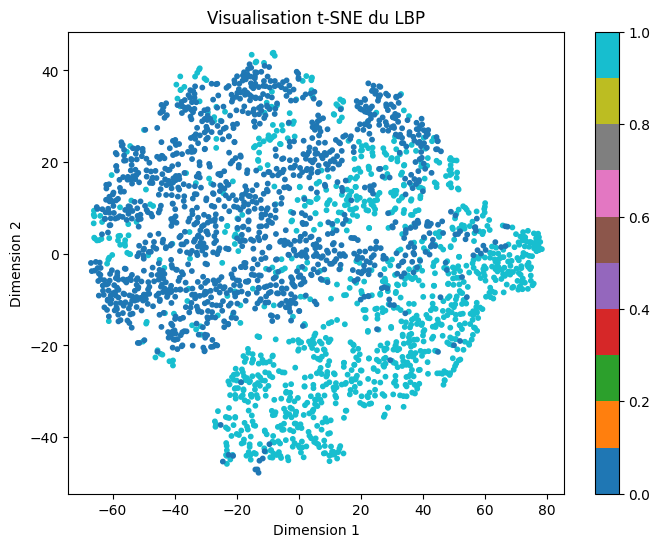

In [24]:
X_scaled_lbp = StandardScaler().fit_transform(X_train_lbp)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled_lbp)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=Y_train_lbp, cmap='tab10', s=10)
plt.colorbar()
plt.title("Visualisation t-SNE du LBP")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### visualisation

c:\Users\Client\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


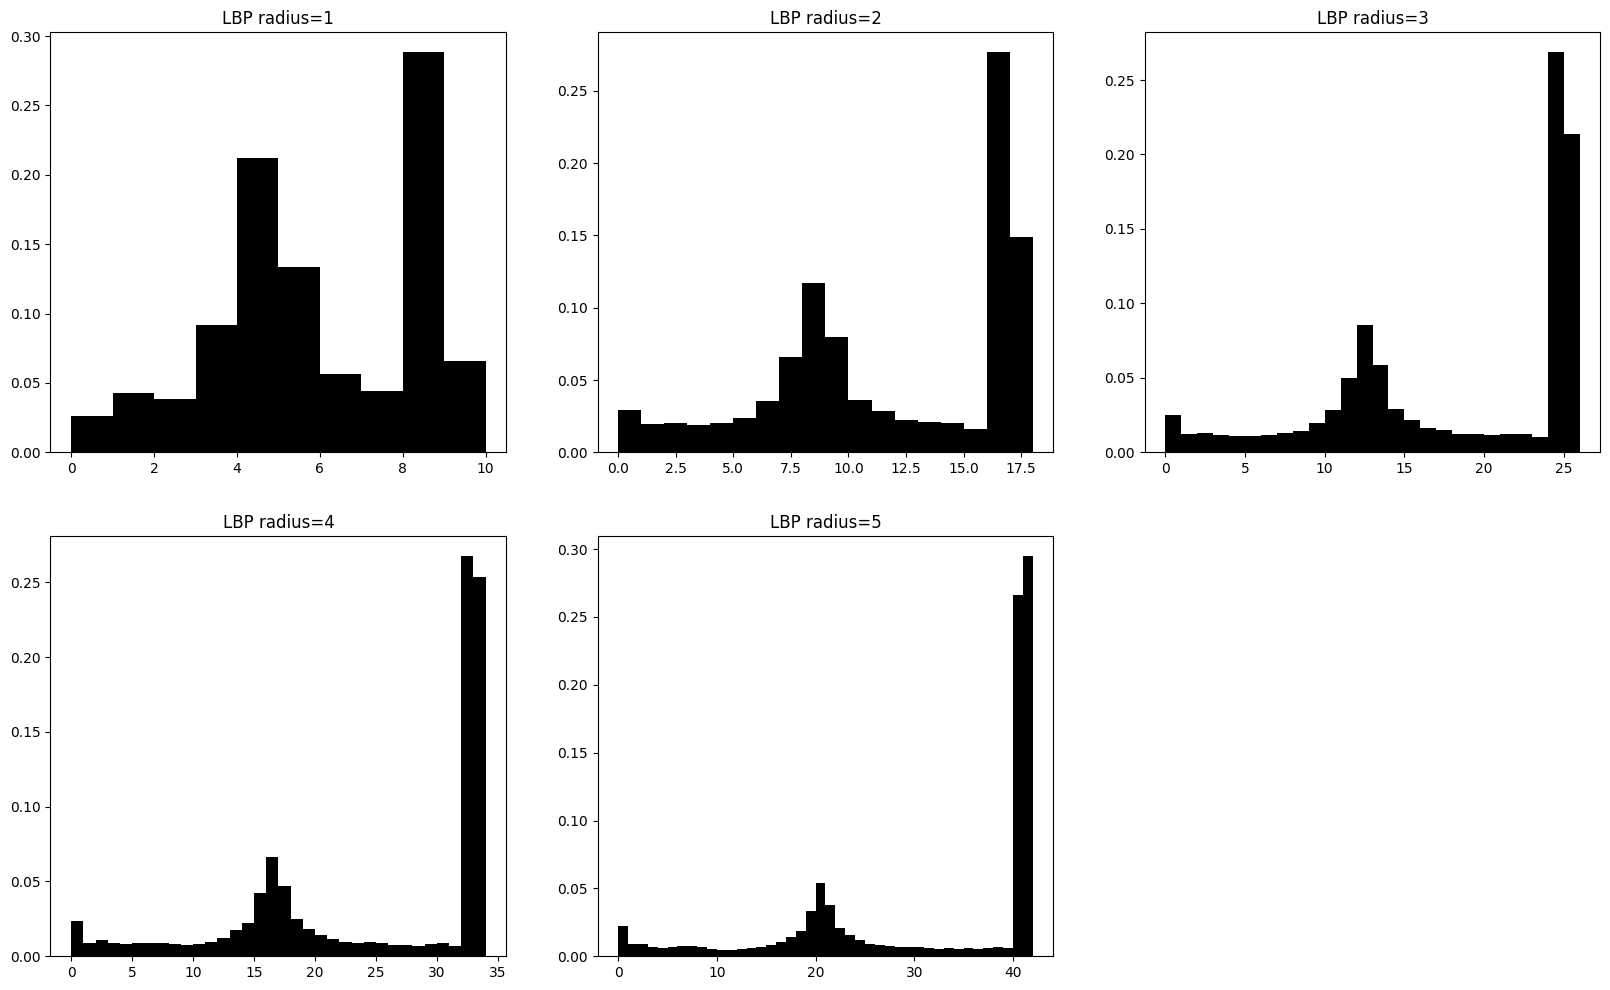

In [25]:
# settings for LBP
r = [1, 2, 3, 4, 5]
n_points = 8

def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(
        lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0'
    )        

images = [preprocess_xray(normal_train[i]) for i in [0]*5]
lbps = [local_binary_pattern(img, n_points * radius, radius, "uniform") for (img, radius) in zip(images, r)]

# plot histograms of LBP of textures
fig, ax_hist = plt.subplots(nrows=2, ncols=3, figsize=(20,12))
plt.gray()
ax_hist = ax_hist.ravel()
# hide any unused subplots (if lbps < number of axes)
for ax in ax_hist[len(lbps):]:
    ax.axis('off')

for ax, lbp, radius in zip(ax_hist, lbps, r):
    ax.set_title(f"LBP radius={radius}")
    counts, _, bars = hist(ax, lbp)

# Classifiers

## Logistic regression

In [27]:
modelLRS = LogisticRegression(class_weight='balanced', max_iter=700)
modelLRS.fit(X_train_st, Y_train_st)
Y_pred_st = modelLRS.predict(X_test_st)

print("\nClassification Report:\n", classification_report(Y_test_st, Y_pred_st))


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.52      0.62       234
           1       0.76      0.90      0.82       390

    accuracy                           0.76       624
   macro avg       0.76      0.71      0.72       624
weighted avg       0.76      0.76      0.74       624



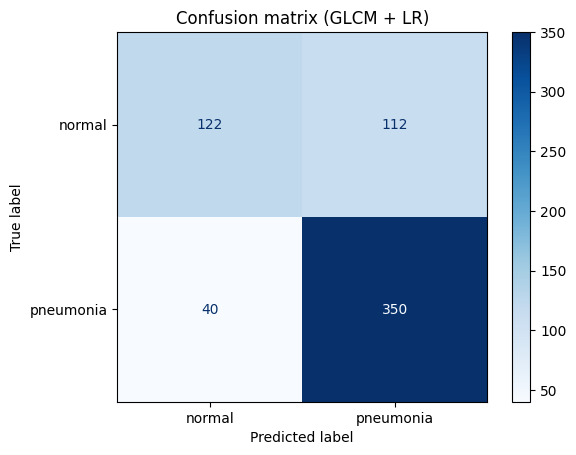

In [28]:
# Plot non-normalized confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    modelLRS,
    X_test_st,
    Y_test_st,
    display_labels=["normal", "pneumonia"],
    cmap=plt.cm.Blues,
)
disp.ax_.set_title("Confusion matrix (GLCM + LR)")

plt.show()

In [29]:
modelLRH = LogisticRegression(class_weight='balanced', max_iter=500)
modelLRH.fit(X_train_hog, Y_train_hog)
Y_pred_hog = modelLRH.predict(X_test_hog)

#print("The coefficients :", modelLRH.coef_, "The bias:", modelLRH.intercept_)
print("\nClassification Report:\n", classification_report(Y_test_hog, Y_pred_hog))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.62      0.75       234
           1       0.81      0.97      0.88       390

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.86      0.84      0.83       624



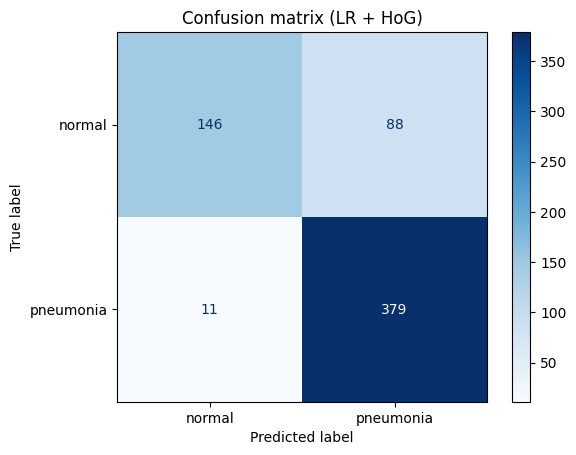

In [30]:
# Plot non-normalized confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    modelLRH,
    X_test_hog,
    Y_test_hog,
    display_labels=["normal", "pneumonia"],
    cmap=plt.cm.Blues,
)
disp.ax_.set_title("Confusion matrix (LR + HoG)")

plt.show()

In [31]:
modelLRL = LogisticRegression(class_weight='balanced', max_iter=500)
modelLRL.fit(X_train_lbp, Y_train_lbp)
Y_pred_lbp = modelLRL.predict(X_test_lbp)

print("\nClassification Report:\n", classification_report(Y_test_lbp, Y_pred_lbp))


Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.53      0.58       234
           1       0.75      0.82      0.78       390

    accuracy                           0.71       624
   macro avg       0.69      0.68      0.68       624
weighted avg       0.70      0.71      0.71       624



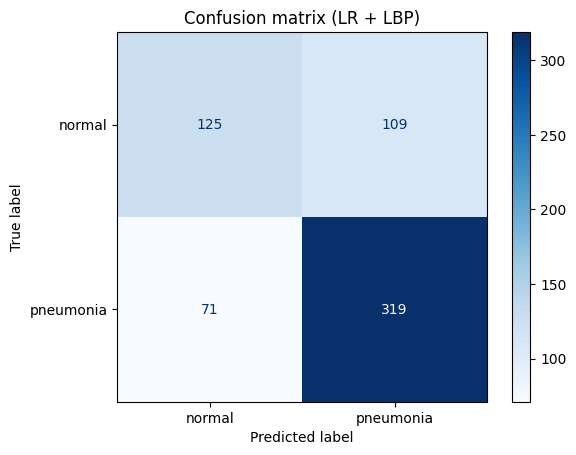

In [32]:
# Plot non-normalized confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    modelLRL,
    X_test_lbp,
    Y_test_lbp,
    display_labels=["normal", "pneumonia"],
    cmap=plt.cm.Blues,
)
disp.ax_.set_title("Confusion matrix (LR + LBP)")

plt.show()

## SVM (Support Vector Machine)

In [33]:
modelSVMH = svm.SVC(class_weight='balanced', kernel='rbf', C=1)

modelSVMH.fit(X_train_hog, Y_train_hog)
Y_pred_hog = modelSVMH.predict(X_test_hog)
print("\nClassification Report:\n", classification_report(Y_test_hog, Y_pred_hog))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.65      0.75       234
           1       0.82      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.82       624
weighted avg       0.85      0.84      0.83       624



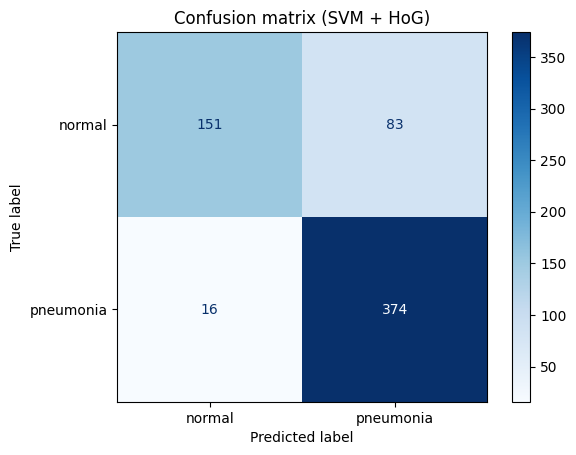

In [34]:
# Plot non-normalized confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    modelSVMH,
    X_test_hog,
    Y_test_hog,
    display_labels=["normal", "pneumonia"],
    cmap=plt.cm.Blues,
)
disp.ax_.set_title("Confusion matrix (SVM + HoG)")

plt.show()

In [35]:
modelSVMS = svm.SVC(class_weight='balanced', kernel='rbf', C=1)
modelSVMS.fit(X_train_st, Y_train_st)
Y_pred_st = modelSVMS.predict(X_test_st)
print("\nClassification Report:\n", classification_report(Y_test_st, Y_pred_st))


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.59      0.65       234
           1       0.78      0.85      0.81       390

    accuracy                           0.75       624
   macro avg       0.74      0.72      0.73       624
weighted avg       0.75      0.75      0.75       624



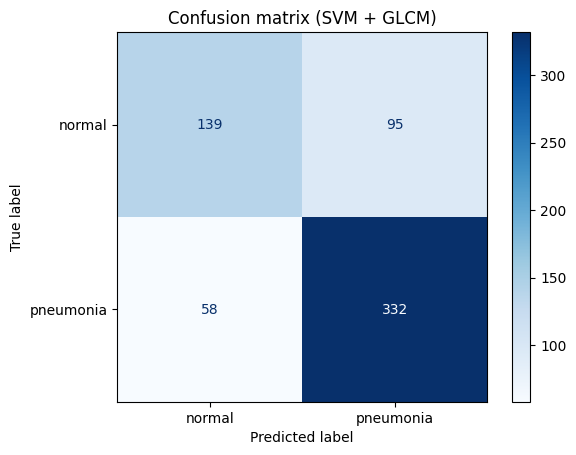

In [36]:
# Plot non-normalized confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    modelSVMS,
    X_test_st,
    Y_test_st,
    display_labels=["normal", "pneumonia"],
    cmap=plt.cm.Blues,
)
disp.ax_.set_title("Confusion matrix (SVM + GLCM)")

plt.show()

In [37]:
modelSVML = svm.SVC(class_weight='balanced', kernel='rbf', C=1)
modelSVML.fit(X_train_lbp, Y_train_lbp)
Y_pred_lbp = modelSVML.predict(X_test_lbp)
print("\nClassification Report:\n", classification_report(Y_test_lbp, Y_pred_lbp))


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.61      0.68       234
           1       0.79      0.89      0.84       390

    accuracy                           0.79       624
   macro avg       0.78      0.75      0.76       624
weighted avg       0.78      0.79      0.78       624



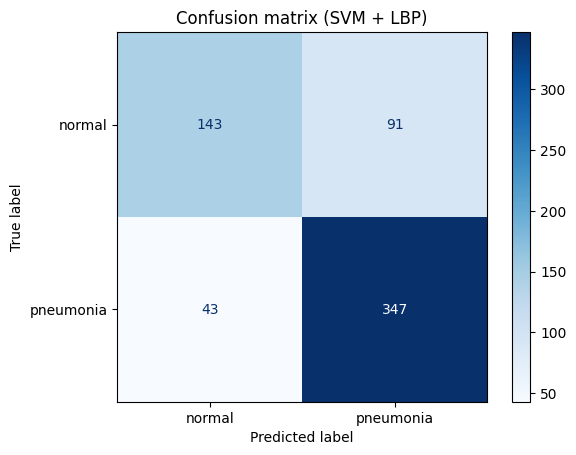

In [38]:
# Plot non-normalized confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    modelSVML,
    X_test_lbp,
    Y_test_lbp,
    display_labels=["normal", "pneumonia"],
    cmap=plt.cm.Blues,
)
disp.ax_.set_title("Confusion matrix (SVM + LBP)")

plt.show()

# Tuning the classifiers

## Grid Search

# CNN

In [39]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

model = models.resnet50(pretrained=True)

# Remove the final classification layer to get feature vectors instead 
# of class scores
feature_extractor = nn.Sequential(*list(model.children())[:-1])
feature_extractor.eval()

# ----  image preprocessing ----
preprocess = transforms.Compose([
     transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(
         mean=[0.485, 0.456, 0.406],  # ImageNet mean
         std=[0.229, 0.224, 0.225]    # ImageNet std
     ),
])

c:\Users\Client\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Client\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### extract features

In [11]:
cnn_trainP = []
cnn_trainN = []
cnn_testP = []
cnn_testN = []

for img_path in pneumonia_train:    
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # add batch dimension

    # ---- Extract features ----
    with torch.no_grad():
        features = feature_extractor(input_tensor)
    features = features.squeeze().numpy()  # shape: (2048,) for ResNet50
    cnn_trainP.append(features)

for img_path in pneumonia_test:    
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # add batch dimension

    # ---- Extract features ----
    with torch.no_grad():
        features = feature_extractor(input_tensor)
    features = features.squeeze().numpy()  # shape: (2048,) for ResNet50
    cnn_testP.append(features)

for img_path in normal_train:    
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # add batch dimension

    # ---- Extract features ----
    with torch.no_grad():
        features = feature_extractor(input_tensor)
    features = features.squeeze().numpy()  # shape: (2048,) for ResNet50
    cnn_trainN.append(features)

for img_path in normal_test:    
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # add batch dimension

    # ---- Extract features ----
    with torch.no_grad():
        features = feature_extractor(input_tensor)
    features = features.squeeze().numpy()  # shape: (2048,) for ResNet50
    cnn_testN.append(features)    

### export data

In [ ]:
df_cnn_trainP = pd.DataFrame(cnn_trainP)
df_cnn_trainP['label'] = 1

df_cnn_testP = pd.DataFrame(cnn_testP)
df_cnn_testP['label'] = 1

df_cnn_trainN = pd.DataFrame(cnn_trainN)
df_cnn_trainN['label'] = 0

df_cnn_testN = pd.DataFrame(cnn_testN)
df_cnn_testN['label'] = 0

cnn_train = pd.concat([df_cnn_trainP[:1200], df_cnn_trainN])
cnn_train.to_csv('data/processed/train_cnn.csv', index=False)

cnn_test = pd.concat([df_cnn_testP, df_cnn_testN])
cnn_test.to_csv('data/processed/test_cnn.csv', index=False)

### import data

In [40]:
# importing data
train_cnn = pd.read_csv('data/processed/train_cnn.csv')
test_cnn = pd.read_csv('data/processed/test_cnn.csv')

# training data
Y_train_cnn = train_cnn['label']
X_train_cnn = train_cnn.drop(columns=['label'])

# testing data
Y_test_cnn = test_cnn['label']
X_test_cnn = test_cnn.drop(columns=['label'])

### classification

In [ ]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=120, random_state=42)),
    ("svm", svm.SVC(
        kernel="rbf",
        C=1,
        gamma="scale",
        class_weight="balanced",
        probability=True
    ))
])

pipeline.fit(X_train_cnn, Y_train_cnn)
Y_pred_cnn = pipeline.predict(X_test_cnn)

print("\nClassification Report:\n", classification_report(Y_test_cnn, Y_pred_cnn))


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.62      0.75       234
           1       0.81      0.98      0.89       390

    accuracy                           0.84       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.84      0.84       624



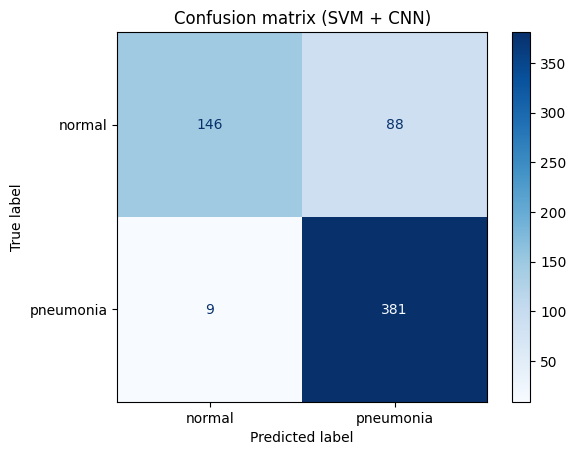

In [42]:
# Plot non-normalized confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    pipeline,
    X_test_cnn,
    Y_test_cnn,
    display_labels=["normal", "pneumonia"],
    cmap=plt.cm.Blues,
)
disp.ax_.set_title("Confusion matrix (SVM + CNN)")

plt.show()

In [44]:
pipelineLR = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=120, random_state=42)),
    ("lr", LogisticRegression(class_weight='balanced', max_iter=500))
])

pipelineLR.fit(X_train_cnn, Y_train_cnn)
Y_pred_cnn_lr = pipelineLR.predict(X_test_cnn)

print("\nClassification Report:\n", classification_report(Y_test_cnn, Y_pred_cnn_lr))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.63      0.75       234
           1       0.81      0.97      0.89       390

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.86      0.84      0.84       624



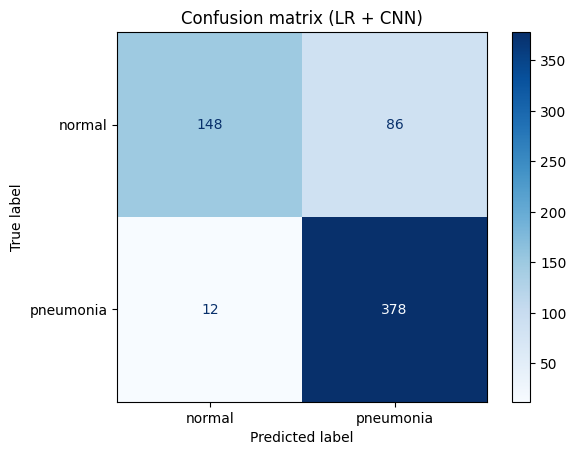

In [45]:
# Plot non-normalized confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    pipelineLR,
    X_test_cnn,
    Y_test_cnn,
    display_labels=["normal", "pneumonia"],
    cmap=plt.cm.Blues,
)
disp.ax_.set_title("Confusion matrix (LR + CNN)")

plt.show()